In [ ]:
#https://www.biorxiv.org/content/10.1101/2022.07.20.500902v1.full.pdf

In [1]:
import torch
model, alphabet = torch.hub.load("facebookresearch/esm:main", "esm2_t33_650M_UR50D")

Downloading: "https://github.com/facebookresearch/esm/zipball/main" to /gpfs/home/nk4167/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t33_650M_UR50D.pt" to /gpfs/home/nk4167/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t33_650M_UR50D-contact-regression.pt" to /gpfs/home/nk4167/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D-contact-regression.pt


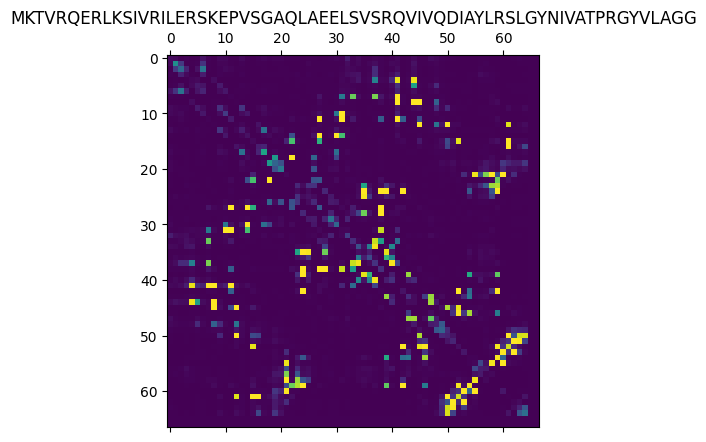

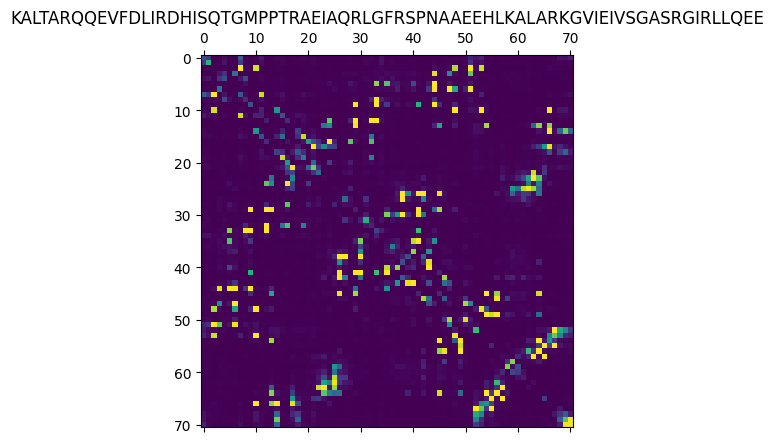

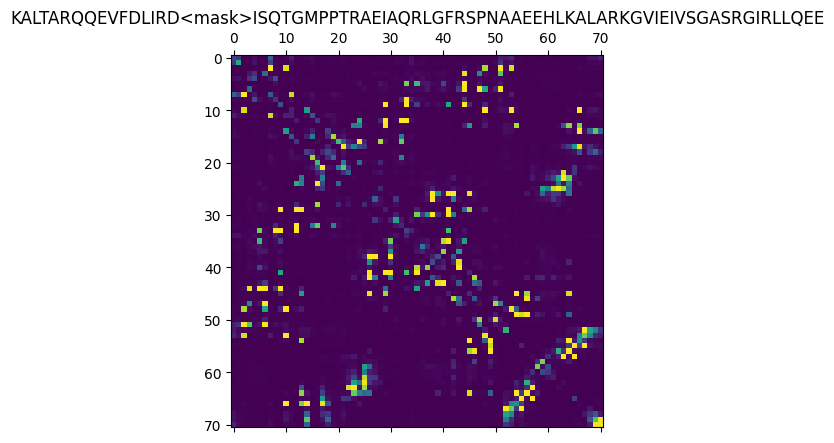

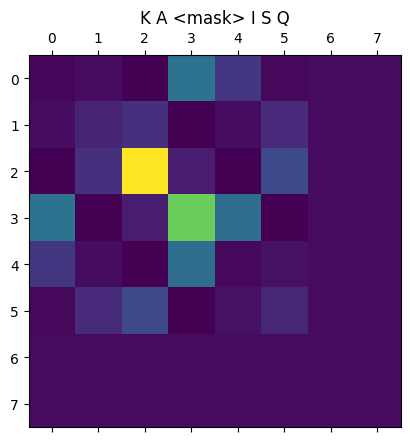

In [2]:
import torch
import esm

# Load ESM-2 model
batch_converter = alphabet.get_batch_converter()
model.eval()  # disables dropout for deterministic results

# Prepare data (first 2 sequences from ESMStructuralSplitDataset superfamily / 4)
data = [
    ("protein1", "MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG"),
    ("protein2", "KALTARQQEVFDLIRDHISQTGMPPTRAEIAQRLGFRSPNAAEEHLKALARKGVIEIVSGASRGIRLLQEE"),
    ("protein2 with mask","KALTARQQEVFDLIRD<mask>ISQTGMPPTRAEIAQRLGFRSPNAAEEHLKALARKGVIEIVSGASRGIRLLQEE"),
    ("protein3",  "K A <mask> I S Q"),
]
batch_labels, batch_strs, batch_tokens = batch_converter(data)
batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

# Extract per-residue representations (on CPU)
with torch.no_grad():
    results = model(batch_tokens, repr_layers=[33], return_contacts=True)
token_representations = results["representations"][33]

# Generate per-sequence representations via averaging
# NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1.
sequence_representations = []
for i, tokens_len in enumerate(batch_lens):
    sequence_representations.append(token_representations[i, 1 : tokens_len - 1].mean(0))

# Look at the unsupervised self-attention map contact predictions
import matplotlib.pyplot as plt
for (_, seq), tokens_len, attention_contacts in zip(data, batch_lens, results["contacts"]):
    plt.matshow(attention_contacts[: tokens_len, : tokens_len])
    plt.title(seq)
    plt.show()

In [10]:
results.keys()

dict_keys(['logits', 'representations', 'attentions', 'contacts'])

In [13]:
results['representations'][33].shape

torch.Size([4, 73, 1280])

In [15]:
results['logits'].shape

torch.Size([4, 73, 33])

In [17]:
results['attentions'].shape

torch.Size([4, 33, 20, 73, 73])

In [19]:
results['contacts'].shape

torch.Size([4, 71, 71])

In [3]:
from transformers import AutoTokenizer, EsmForMaskedLM
import torch
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display

def generate_heatmap(protein_sequence, start_pos=1, end_pos=None):
    # Load the model and tokenizer
    model_name = "facebook/esm2_t6_8M_UR50D"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = EsmForMaskedLM.from_pretrained(model_name)

    # Tokenize the input sequence
    input_ids = tokenizer.encode(protein_sequence, return_tensors="pt")
    sequence_length = input_ids.shape[1] - 2  # Excluding the special tokens

    # Adjust end position if not specified
    if end_pos is None:
        end_pos = sequence_length

    # List of amino acids
    amino_acids = list("ACDEFGHIKLMNPQRSTVWY")

    # Initialize heatmap
    heatmap = np.zeros((20, end_pos - start_pos + 1))

    # Calculate LLRs for each position and amino acid
    for position in range(start_pos, end_pos + 1):
        # Mask the target position
        masked_input_ids = input_ids.clone()
        masked_input_ids[0, position] = tokenizer.mask_token_id
        
        # Get logits for the masked token
        with torch.no_grad():
            logits = model(masked_input_ids).logits
            
        # Calculate log probabilities
        probabilities = torch.nn.functional.softmax(logits[0, position], dim=0)
        log_probabilities = torch.log(probabilities)
        
        # Get the log probability of the wild-type residue
        wt_residue = input_ids[0, position].item()
        log_prob_wt = log_probabilities[wt_residue].item()
        
        # Calculate LLR for each variant
        for i, amino_acid in enumerate(amino_acids):
            log_prob_mt = log_probabilities[tokenizer.convert_tokens_to_ids(amino_acid)].item()
            heatmap[i, position - start_pos] = log_prob_mt - log_prob_wt

    # Visualize the heatmap
    plt.figure(figsize=(15, 5))
    plt.imshow(heatmap, cmap="viridis", aspect="auto")
    plt.xticks(range(end_pos - start_pos + 1), list(protein_sequence[start_pos-1:end_pos]))
    plt.yticks(range(20), amino_acids)
    plt.xlabel("Position in Protein Sequence")
    plt.ylabel("Amino Acid Mutations")
    plt.title("Predicted Effects of Mutations on Protein Sequence (LLR)")
    plt.colorbar(label="Log Likelihood Ratio (LLR)")
    plt.show()

def interactive_heatmap(protein_sequence):
    # Define interactive widgets
    start_slider = widgets.IntSlider(value=1, min=1, max=len(protein_sequence), step=1, description='Start:')
    end_slider = widgets.IntSlider(value=len(protein_sequence), min=1, max=len(protein_sequence), step=1, description='End:')

    ui = widgets.HBox([start_slider, end_slider])

    def update_heatmap(start, end):
        if start <= end:
            generate_heatmap(protein_sequence, start, end)

    out = widgets.interactive_output(update_heatmap, {'start': start_slider, 'end': end_slider})

    # Display the interactive widgets
    display(ui, out)


/gpfs/scratch/nk4167/miniconda/lib/python3.12/site-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
2025-04-03 07:07:12.257758: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743678432.322920 2873138 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743678432.342537 2873138 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-03 07:07:12.489148: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the follow

In [4]:
# Example usage:
protein_sequence = "MAPLRKTYVLKLYVAGNTPNSVRALKTLNNILEKEFKGVYALKVIDVLKNPQLAEEDKILATPTLAKVLPPPVRRIIGDLSNREKVLIGLDLLYEEIGDQAEDDLGLE"
interactive_heatmap(protein_sequence)


Output()